In [1]:
import sys, os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from time import sleep

from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D, MaxPool2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.utils import np_utils
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

C:\Apps\anaconda3\envs\usabcheckEnv2\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (2.0.3) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.


In [2]:
# model = load_model(r'C:\Users\New User\Desktop\Fourth Year\Usability_Testing_FYP\Src\Model1.h5')

json_file = open('C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Src/Model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("Model2_Weights.h5")

In [3]:
""" ------------------------------------------------------
    Plot Confusion Matrix
------------------------------------------------------ """

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, plotIndex=1, fig=plt.figure(num=None, figsize=(20, 30), dpi=80, facecolor='w', edgecolor='k')):
    fig.add_subplot(9, 2, plotIndex)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        pass
        # print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<Figure size 1600x2400 with 0 Axes>

In [4]:
""" ------------------------------------------------------
    Make Predictions on Dataset
    
    NOTE: I wrote this function because I was having issues with the keras generators.
          The problem is now fixed, however, the code below still works perfectly fine.
------------------------------------------------------ """

# Model 1
# dataLabels = {
#     "Angry": 0, "Disgust": 1, "Fear": 2, "Happy": 3, "Neutral": 4, "Sad": 5, "Surprise": 6 
# }
# Model 2
dataLabels = {
    "Angry": 0, "Disgust": 1, "Fear": 2, "Happy": 3, "Sad": 4, "Surprise": 5, "Neutral": 6 
}

faceDetector = cv2.CascadeClassifier(r'haarcascade_frontalface_default.xml')

# Make prediction for model 1
def makePredictions(model, datasetDirectory):
    global dataLabels
    
    predicted = []
    actual = []
    
    labels = list(dataLabels.keys()) #["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
        
    emotionDirList = os.listdir(datasetDirectory)
    for folder in emotionDirList:
        # Folder exists but has not been selected so we ignore it
        if folder not in dataLabels.keys():
            continue
        
        label = dataLabels[folder]
        
        # Iterate over the images
        imageList = os.listdir(datasetDirectory + "/" + folder)
        for imgName in imageList:
            img = cv2.imread(datasetDirectory + '/'+ folder + '/'+ imgName)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            gray = cv2.resize(gray, (48,48), interpolation=cv2.INTER_AREA)
            roi = gray.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0)
            preds = model.predict(roi)[0]
            predictedlabel = labels[preds.argmax()]
            
            predicted.append(preds.argmax())
            actual.append(label)
    
    return predicted, actual

In [5]:
""" ------------------------------------------------------
    Get Predicition Data
------------------------------------------------------ """

# Disable if you have already made the calculation
calculatePredictions = True

testDatasets = {
    "JAFFE": 'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/JAFFE/Categorised',
    "JAFFE (Face Crop)":   'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/JAFFE/JustFace',
    "FacesDB (Face Crop)": 'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/FacesDB/JustFace',
    "FER2013 (Test Set)":  'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/FER2013/Images/PrivateTest'
}

if calculatePredictions:
    resultDict = {}
    
    # Make Predictions
    for datasetTitle in testDatasets.keys():
        datasetPath = testDatasets[datasetTitle]
        predicted, actual = makePredictions(model, datasetPath)

        resultDict[datasetTitle] = {
            "predicted": predicted,
            "actual": actual
        }

In [6]:
print(list(dataLabels.keys()))

['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


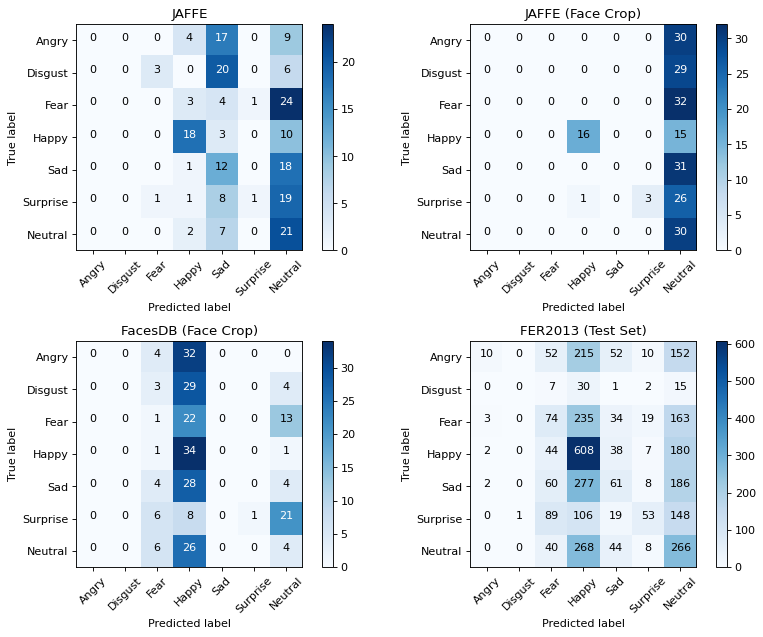

In [7]:
""" ------------------------------------------------------
    Display Results (Confusion Matrix)
------------------------------------------------------ """


# Model 1
# emotionList = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
# Model 2
# emotionsList = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

emotionsList = list(dataLabels.keys())

plotIndex = 1
fig = plt.figure(num=None, figsize=(10, 35), dpi=80, facecolor='w', edgecolor='k')
for datasetTitle in resultDict:
    actual = resultDict[datasetTitle]["actual"]
    predicted = resultDict[datasetTitle]["predicted"]
    
    cm = confusion_matrix(y_true = actual, y_pred = predicted)
    plot_confusion_matrix(cm=cm, classes=emotionsList, title=datasetTitle, plotIndex=plotIndex, fig=fig)
    plotIndex += 1

In [8]:
""" ------------------------------------------------------
    Display Results (Classification Report)
------------------------------------------------------ """

import warnings
# A warning is thrown because sometimes there prediction has been made 0 times
warnings.filterwarnings('ignore')

reportData = {}

for datasetTitle in resultDict:
    print("----------------------", datasetTitle, "----------------------\n")
    actual = resultDict[datasetTitle]["actual"]
    predicted = resultDict[datasetTitle]["predicted"]
    report = classification_report(actual, predicted)
    reportDict = classification_report(actual, predicted, output_dict=True)
    reportData[datasetTitle] = reportDict
    print(report)
    print("\n\n\n")
    
warnings.filterwarnings('default')

---------------------- JAFFE ----------------------

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.00      0.00      0.00        29
           2       0.00      0.00      0.00        32
           3       0.62      0.58      0.60        31
           4       0.17      0.39      0.24        31
           5       0.50      0.03      0.06        30
           6       0.20      0.70      0.31        30

    accuracy                           0.24       213
   macro avg       0.21      0.24      0.17       213
weighted avg       0.21      0.24      0.17       213





---------------------- JAFFE (Face Crop) ----------------------

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.00      0.00      0.00        29
           2       0.00      0.00      0.00        32
           3       0.94      0.52      0.67        31
          

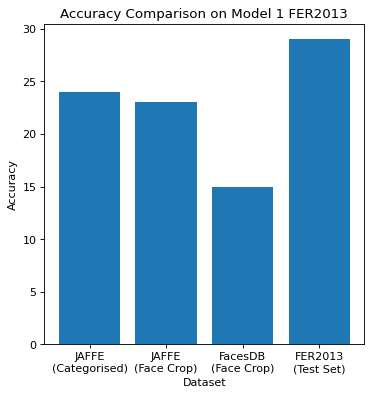

In [10]:
""" ------------------------------------------------------
    Display Accuracy Comparisons
------------------------------------------------------ """

import matplotlib.pyplot as plt
fig = plt.figure(num=None, figsize=(4, 4), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])
datasetTitles = []
accuracies = []

titleDisplayPair = {
    "JAFFE": "JAFFE\n(Categorised)",
    "JAFFE (Face Crop)": "JAFFE\n(Face Crop)",
    "FacesDB (Face Crop)": "FacesDB\n(Face Crop)",
    "FER2013 (Test Set)":  "FER2013\n(Test Set)"
}

for title in reportData:
    datasetTitles.append(titleDisplayPair[title])
    accuracy = int(reportData[title]["accuracy"] * 100)
    accuracies.append(accuracy)

ax.bar(datasetTitles, accuracies)
ax.set_xlabel('Dataset')
ax.set_title('Accuracy Comparison on Model 1 FER2013')
ax.set_ylabel('Accuracy')
# ax.set_ylim([0,100])
plt.show()

In [ ]:
""" ------------------------------------------------------
    Extract the Faces out of Dataset
------------------------------------------------------ """

datasetDirectory = 'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/FacesDB/Categorised'
destinationDirectory = 'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/FacesDB/JustFace'

dataLabels = {
    "Angry": 0, "Disgust": 1, "Fear": 2, "Happy": 3, "Neutral": 4, "Sad": 5, "Surprise": 6 
}

faceDetector = cv2.CascadeClassifier(r'haarcascade_frontalface_default.xml')

def extractFaceDataset(datasetDirectory, destinationDirectory):
    global dataLabels
    
    labels = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
    predictCount = {}
        
    emotionDirList = os.listdir(datasetDirectory)
    for folder in emotionDirList:
        # Folder exists but has not been selected so we ignore it
        if folder not in dataLabels.keys():
            continue
        
        label = dataLabels[folder]
        
        # Iterate over the images
        imageList = os.listdir(datasetDirectory + "/" + folder)
        for imgName in imageList:
            img = cv2.imread(datasetDirectory + '/'+ folder + '/'+ imgName)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            faces = faceDetector.detectMultiScale(gray, 1.3, 5)
            
            # Iterate over the faces (bounding boxes)
            for (x, y, w, h) in faces:
                croppedFace = gray[y:y+h, x:x+w]
                # Resize the face to the size the classifier expects (48 x 48)
                croppedFace = cv2.resize(croppedFace, (48,48), interpolation=cv2.INTER_AREA)

                # If a face has been detected and the image has pixel values
                if np.sum([croppedFace]) != 0:
                    outputDir = destinationDirectory + '/'+ folder + '/'+ imgName
                    cv2.imwrite(outputDir, croppedFace)

# extractFaceDataset(datasetDirectory, destinationDirectory)